In [1]:
import pandas as pd
import numpy as np
import skimage as ski
from skimage import io as skio
import matplotlib.pyplot as plt
import cv2 as cv
from numba import jit 

def show(im, title="", size=7):
    plt.figure( figsize=(size,size))
    plt.imshow(im, cmap='gray')
    plt.title(title)
    plt.show()

In [42]:
from matplotlib.dates import DAYS_PER_YEAR
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

@jit(nopython=True)
def normalize(im):
    return (im - im.min()) / (im.max() - im.min())

@jit(nopython=True)
def pixel_entropy(im, prob):
    entropy = np.zeros(im.shape, dtype=float)
    for i in range(entropy.shape[0]):
        for j in range(entropy.shape[1]):
            if prob[im[i,j]] == 0:
                entropy[i,j] = 0
            else:
                entropy[i,j] = - prob[im[i,j]] * np.log2(prob[im[i,j]])
    entropy = normalize(entropy)
    return entropy

#@jit(nopython=True)
def superpixel_entropy(entropy, segments):
#    entropy_values = (segments.max()+1) * [[]]
#    for i in range(segments.shape[0]):
#        for j in range(segments.shape[1]):
#            entropy_values[segments[i,j]].append(entropy[i,j])
    #print("entropy values", entropy_values[0], entropy_values[1])

    superpixel_entropy = np.zeros(segments.max()+1, dtype=float)
    for i in range(segments.max()+1):
        mask = segments == i
        masked_entropy = mask * entropy
        superpixel_entropy[i] = np.sum(masked_entropy)
        #superpixel_entropy[i] = sum(entropy_values[i]) #/ len(entropy_values[i])
        
    #print("superpixel entropy", superpixel_entropy)

    superpixel_entropy_image = np.zeros(segments.shape, dtype=float)
    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            superpixel_entropy_image[i,j] = superpixel_entropy[segments[i,j]]

    superpixel_entropy_image = normalize(superpixel_entropy_image)
    return superpixel_entropy_image

def information_saliency(im, n_segments = 1000, sigma = 1, wl = 1./3, wa = 1./3, wb = 1./3):
    im_lab = ski.color.rgb2lab(im)
    segments = slic(im_lab, n_segments = n_segments, sigma = sigma, convert2lab=False)
    show(mark_boundaries(im, segments))

    superpixel_entropy_image = [None] * im.shape[2]
    for c in range(im.shape[2]):  
        hist, bin_edges = np.histogram(im[:,:,c], bins=256)
        prob = hist / im.size
        pixel_entropy_image = pixel_entropy(im[:,:,c], prob)
        superpixel_entropy_image[c] = superpixel_entropy(pixel_entropy_image, segments)
        
        show(pixel_entropy_image)
        show(superpixel_entropy_image[c])

    entropy = superpixel_entropy_image[0]*wl + superpixel_entropy_image[1]*wa + superpixel_entropy_image[2]*wb
    entropy = np.array(entropy)
    return entropy

<ipython-input-42-e962d2ae1485>:50: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(im_lab, n_segments = n_segments, sigma = sigma, convert2lab=False)


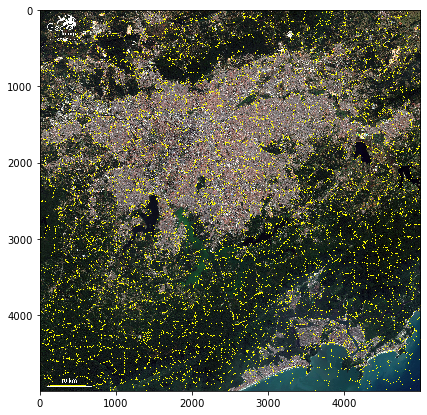

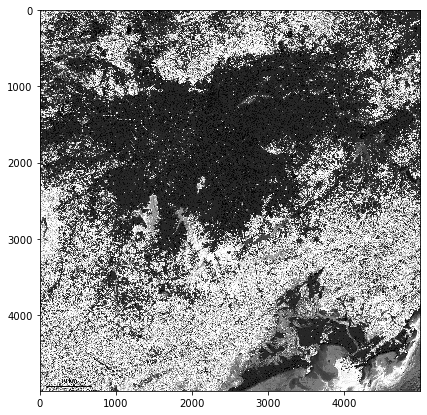

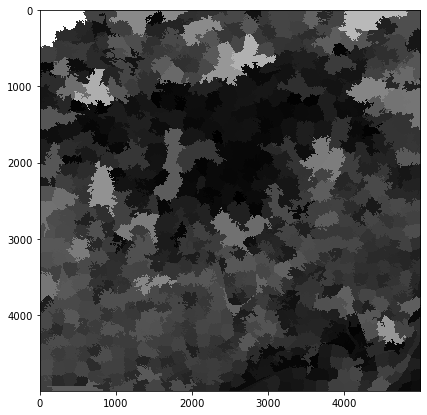

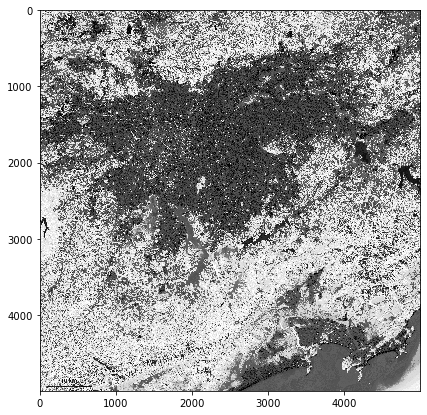

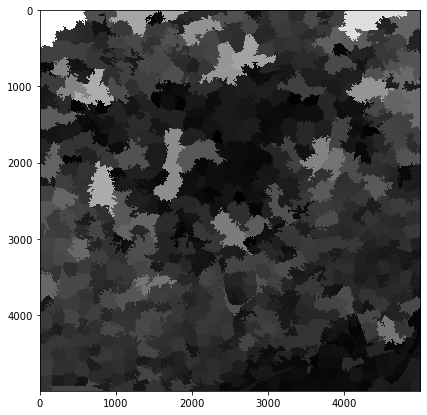

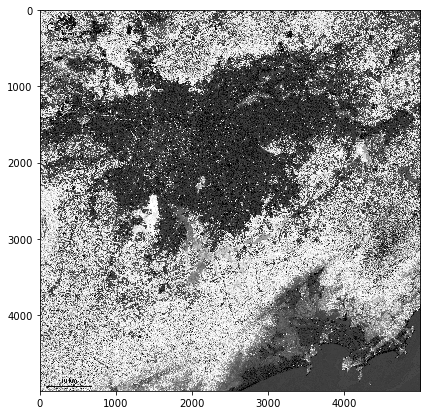

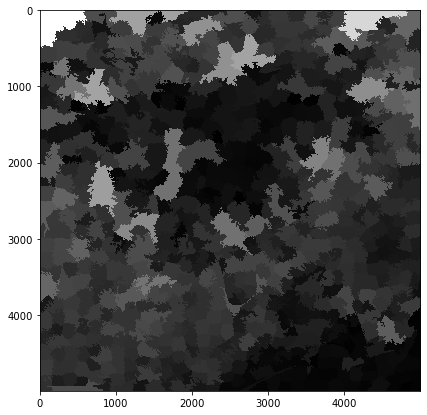

In [44]:
im = skio.imread('imgs/sp.jpg')
entropy = information_saliency(im[:, :, :], n_segments=1000)


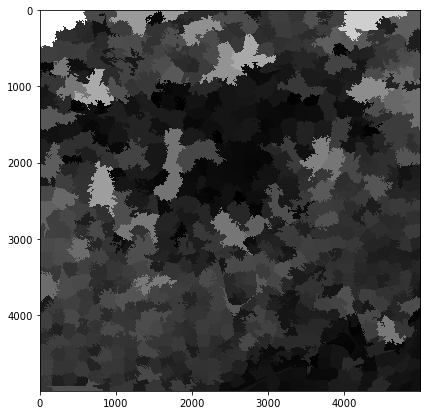

In [45]:
show(entropy)

In [15]:
bins

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [ ]:
im = skio.imread('imgs/sp.jpg')
im_lab = ski.color.rgb2lab(im)
segments = slic(im_lab, n_segments = 1000, sigma = 1, convert2lab=False)
print(segments)

In [5]:
@jit(nopython=True)
def pixel_saliency(value, hist):
    counter = 0
    for pixel_value, frequency in enumerate(hist):
            counter += abs(value - pixel_value) * frequency
    return counter

@jit(nopython=True)
def single_channel_saliency(im, hist):
    saliency = np.zeros(im.shape)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            saliency[i,j] = pixel_saliency(im[i,j], hist)
    return saliency

#@jit(nopython=False)
def statistical_saliency(im, wl = 1./3, wa = 1./3, wb = 1./3, sigma = 1):
    im_lab = ski.color.rgb2lab(im)
    saliency = np.zeros(im.shape)
    for c in range(im.shape[2]):
        hist, bin_edges = np.histogram(im_lab[:,:,c], bins=256, range=(0,1))
        saliency[:,:,c] = single_channel_saliency(im_lab[:,:,c], hist)
    
    saliency_mean = saliency[:,:,0]*wl + saliency[:,:,1]*wa + saliency[:,:,2]*wb
    filtered_saliency = cv.GaussianBlur(saliency_mean, (3,3), sigma)
    return filtered_saliency

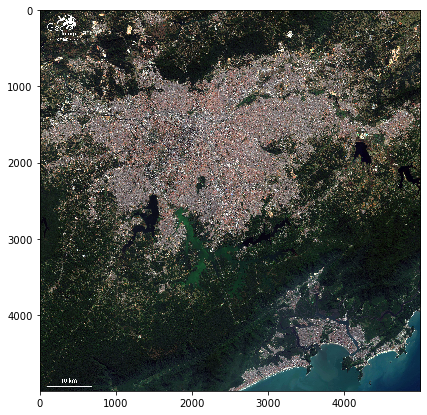

In [5]:
im = skio.imread('imgs/sp.jpg')/255
show(im)

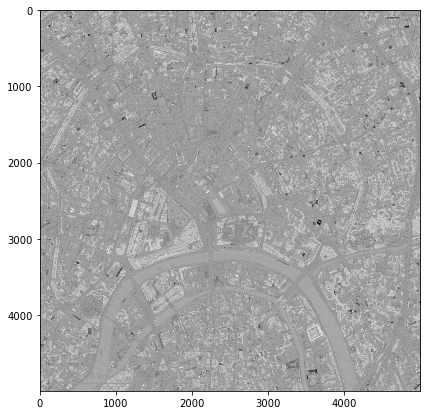

In [7]:
im = skio.imread('imgs/moscou.jpg')
saliency = statistical_saliency(im, wl = 0, wa=1, wb=0, sigma=0)
show(saliency)

200749.0

In [31]:
im_lab = ski.color.rgb2lab(im[0:1000, 0:1000, :]/255)

In [32]:
saliency = np.zeros(im_lab.shape)
for c in range(im_lab.shape[2]):
    hist, bin_edges = np.histogram(im_lab[:,:,c], bins=256, range=(0,1))
    for i in range(im_lab.shape[0]):
        for j in range(im_lab.shape[1]):
            saliency[i,j,c] = pixel_saliency(im_lab[i,j,c], hist)

plt.imshow(saliency[:,:,0])

KeyboardInterrupt: 

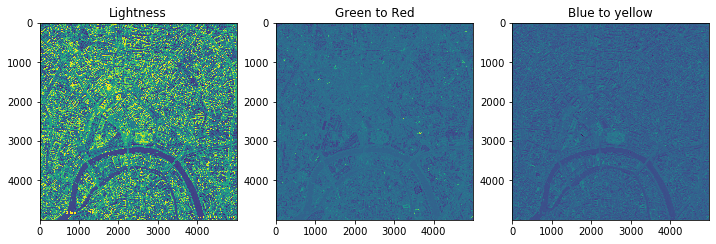

In [20]:
fig, ax = plt.subplots(1,3, figsize=(12,12))
ax[0].imshow(im_lab[:,:,0]) 
ax[0].set_title('Lightness')
ax[1].imshow(im_lab[:,:,1])
ax[1].set_title('Green to Red')
ax[2].imshow(im_lab[:,:,2])
ax[2].set_title('Blue to yellow')
plt.show()

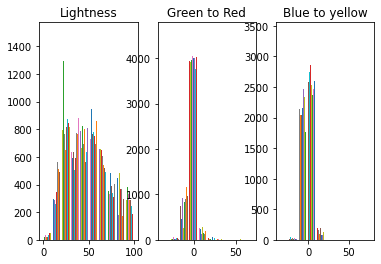

In [24]:
fig, ax = plt.subplots(1,3)
ax[0].hist(im_lab[:,:,0]) 
ax[0].set_title('Lightness')
ax[1].hist(im_lab[:,:,1])
ax[1].set_title('Green to Red')
ax[2].hist(im_lab[:,:,2])
ax[2].set_title('Blue to yellow')
plt.show()

In [6]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

@jit(nopython=True)
def information_saliency_loop(segments, prob):
    saliency = np.zeros(segments.shape)
    for i in range(saliency.shape[0]):
        for j in range(saliency.shape[1]):
            saliency[i,j] = - prob[segments[i,j]] * np.log2(prob[segments[i,j]])
    return saliency

def information_saliency(im, n_segments = 1000, sigma = 1):
    im_lab = ski.color.rgb2lab(im)
    segments = slic(im_lab, n_segments = n_segments, sigma = sigma, convert2lab=False)
    show(mark_boundaries(im, segments))
    for c in range(im.shape[2]):  
        hist, bin_edges = np.histogram(im_lab[:,:,c], bins=segments.max()+1)
        prob = hist / im.size
    saliency = information_saliency_loop(segments, prob)
    
    return saliency

In [38]:
im = skio.imread('imgs/sp.jpg')
im_lab = ski.color.rgb2lab(im)
segments = slic(im_lab, n_segments = 1000, sigma = 1, convert2lab=False)
print(segments)

<ipython-input-38-847c2720ed24>:2: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(im_lab, n_segments = 1000, sigma = 1, convert2lab=False)


[[  0   0   0 ...  10  10  10]
 [  0   0   0 ...  10  10  10]
 [  0   0   0 ...  10  10  10]
 ...
 [224 224 224 ... 267 267 267]
 [224 224 224 ... 267 267 267]
 [224 224 224 ... 267 267 267]]


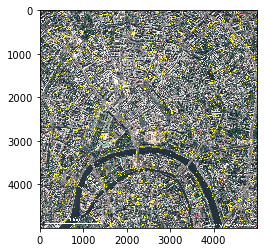

In [39]:
plt.imshow(mark_boundaries(im, segments))

<ipython-input-6-0cddbde201cc>:17: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = slic(im_lab, n_segments = n_segments, sigma = sigma, convert2lab=False)


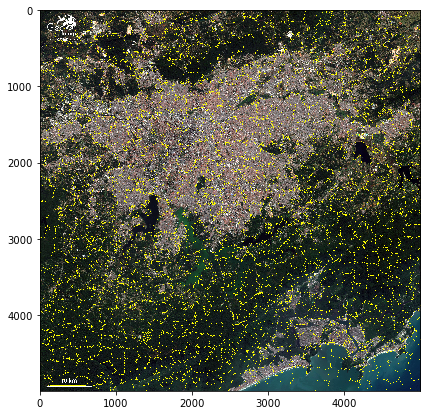

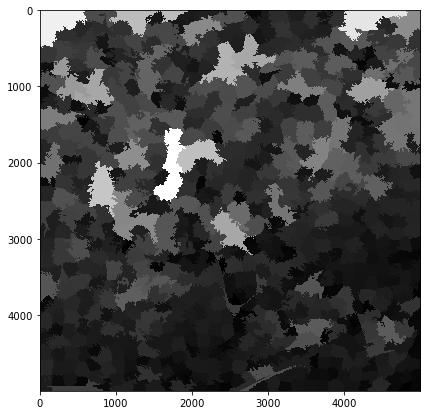

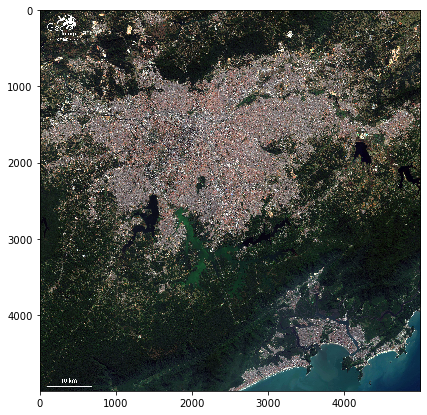

In [7]:
im = skio.imread('imgs/sp.jpg')/255
saliency = information_saliency(im)
show(saliency)
show(im)

In [23]:
hist, bin_edges = np.histogram(segments, bins = segments.max()+1)
print(hist)

263


1309

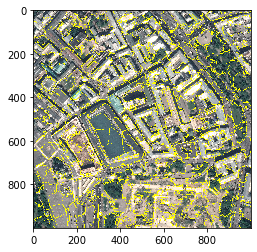

In [7]:
plt.imshow(mark_boundaries(im[2000:3000, 2000:3000, :], segments))

In [80]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

for numSegments in (1, 500):
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = slic(im, n_segments = numSegments, sigma = 1, convert2lab=True)
	# show the output of SLIC
	fig = plt.figure("Superpixels -- %d segments" % (numSegments))
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(mark_boundaries(im, segments))
	plt.axis("off")
# show the plots
plt.show()

: 

: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


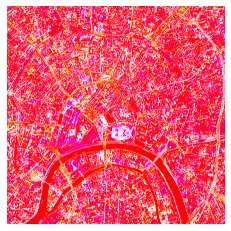

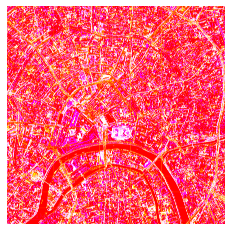

In [5]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

for numSegments in (1, 200):
	# apply SLIC and extract (approximately) the supplied number
	# of segments
	segments = slic(im, n_segments = numSegments, sigma = 1, convert2lab=True)
	# show the output of SLIC
	fig = plt.figure("Superpixels -- %d segments" % (numSegments))
	ax = fig.add_subplot(1, 1, 1)
	ax.imshow(mark_boundaries(im, segments))
	plt.axis("off")
# show the plots
plt.show()

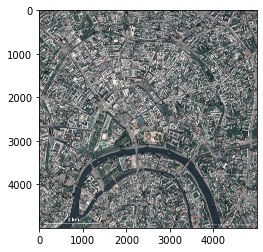

In [7]:
plt.imshow(mark_boundaries(im, segments, color=0, outline_color=0, mode='inner'))

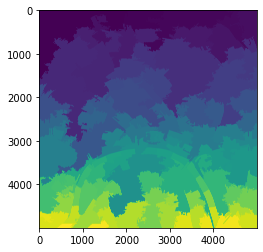

In [5]:
plt.imshow(segments)

In [3]:
counter = 0
from tqdm import tqdm
for i in tqdm(range(4000)):
    for j in range(4000):
        for k in range(4000):
            for m in range(4000):
                counter += 1

counter

  0%|          | 0/4000 [00:54<?, ?it/s]


KeyboardInterrupt: 